# This notebook for preprocessing and deep-learning model model implemented using pytorch of the Devices-Price-Classification-System project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing libraries

In [2]:
# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import joblib
import pickle
import seaborn as sns
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
import tensorflow as tf
#from keras import backend as K


In [14]:
# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# printing pytorch version as this point may affect the reproducability if diffrent pytorch version used
print(f'using version {tf.__version__}')


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, tensorflow

    This function to be able to reproduce the same numbers in the future, by fixing
    the algorithms parameters that lead to generate the same random numbers

    Args:
        seed (int): Seed to be used.
    """

    #
    os.environ['PYTHONHASHSEED']=str(seed)

    # set seed for python random numbers.Set `python` pseudo-random generator at a fixed value
    random.seed(seed)

    # set seed for numpy random numbers. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed)

    #GLOBAL SEED:- set seed for tensorflow random numbers.  Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed)

    # tf gpu fix seed, please `pip install tensorflow-determinism` first
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


    # sets seeds for keras
    tf.keras.utils.set_random_seed(seed)

    # forcing tensorflow to use single thread since multiple threads are potential source of un-reproducibility
    # Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    # # if if speed is less important than reproducibility then un-comment this line, as it will reduce the calculations-speed significantly but will leads to more robust reproducibility
    # tf.config.experimental.enable_op_determinism()

seed=7
set_random_seed(seed=seed)

using version 2.15.0


## load data

In [4]:
project_path = os.path.abspath(os.path.join("." ,".."))
df = pd.read_csv(f"{project_path}/data/train - train.csv")
test_data = pd.read_csv(f"{project_path}/data/test - test.csv")

split the label column from the feature columns

In [5]:
# label column naming it (y)
y = df["price_range"]
#feature columns naming them x
x = df.drop("price_range", axis=1)
y = tf.keras.utils.to_categorical(y, num_classes=4)
y.shape, x.shape


((2000, 4), (2000, 20))

#### using train test split function to split the training data into training and validation set

In [6]:
from sklearn.model_selection import train_test_split
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(
    x, y, test_size=0.17, random_state=seed, stratify=y, shuffle=True)

we will do all the preprocessing steps using the make_column_transformer this has many advantages, such as we can involve the preprocessing step in the fine tuning process, and we dont need the repeat the same steps for testing data step by step

In [7]:
preprocessor_1 = make_column_transformer((MinMaxScaler(feature_range=(0, 3)), ["ram"]),
                                          remainder="passthrough")

preprocessor_2 = make_column_transformer(
    #(KNNImputer(), slice(0, k)),  # test this choice, but it leads to poor results
     (IterativeImputer(random_state=seed, tol=1e-5, max_iter=55), slice(0, 20)),
     remainder="passthrough")

preprocessor_3 = make_column_transformer((StandardScaler(), slice(1, 20)),
                                         remainder="passthrough")

# by the way deep-learning can deal with unscaled features, but anyway i did StandardScaler, MinMaxScaler steps

#### machine learning is a search problem

In [8]:

pipe = make_pipeline(preprocessor_1, preprocessor_2, preprocessor_3)

# apply the needed transformations over the training data
xtrain = pipe.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = pipe.transform(xtest_unprocessed)

In [9]:
number_of_output_layer_neurons = ytrain.shape[1]
number_of_input_layer_neurons = xtrain.shape[1]

#compine the features and the corresponding labels into one object
train_set = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))

#compine the features and the corresponding labels into one object
test_set = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [19]:
#initializing accuracy function
accuracy = tf.keras.metrics.Accuracy(name='accuracy')

#initializing cross_entropy_loss function
cross_entropy_loss = tf.keras.metrics.CategoricalCrossentropy(name='cross_entropy_loss')

#initializing f1score function
f1score = tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1score', dtype=tf.float32)

# evaluate the performance using the R2Score and mean-square-error pytorch functions
def evaluate_model(model, data_loader):
    '''this function is to evaluate the performance of the model using R2Score and mean-square-error pytorch functions'''

    # initialize the labels and preds and transfering them to device(cpu or gpu)
    labels = tf.constant([], dtype=tf.float32, shape=(0, number_of_output_layer_neurons))
    predictions = tf.constant([], dtype=tf.float32, shape=(0, number_of_output_layer_neurons))

    # starting the loop over data
    for features, label in data_loader:

        # concatenate all the labels
        labels = tf.concat(values=[labels, label ], axis=0)

        # get the model predictions of the given data and flatten them
        preds = model(features, training=False)

        # concatenate all the predictions
        predictions = tf.concat(values=[preds, predictions], axis=0)

    # calculate cross_entropy_loss
    cross_entropy_loss.reset_state()
    cross_entropy_loss.update_state(labels, predictions)
    cross_entropy_loss_evaluation = cross_entropy_loss.result().numpy()

    #print(f" preds shape = {preds.shape}")
    #print(f" labels shape = {labels.shape}")
    #print(f" label shape = {label.shape}")
    #print(f"predictionss shape =  {predictions.shape}")

    # calculate accuracy
    accuracy.reset_state()
    accuracy.update_state(tf.argmax(labels, axis=1), tf.argmax(predictions, axis=1))
    accuracy_evaluation = accuracy.result().numpy()

    # calculate f1score
    f1score.reset_state()
    f1score.update_state(labels, predictions)
    f1score_evaluation = f1score.result().numpy()

    # evaluation metrics
    model_evaluations = np.array([accuracy_evaluation, cross_entropy_loss_evaluation, f1score_evaluation], dtype=np.float32)

    # return the model_evaluations result
    return model_evaluations

#evaluate_model(model, data_loader=test_loader)

In [11]:
class network(tf.keras.Model):
    '''create the structure of the model'''

    def __init__(self, number_of_input_layer_neurons=20, number_of_output_layer_neurons=4):
        '''like a class constructor function or initialization'''

        super().__init__()
        # the fully connected layers
        self.fc1 = tf.keras.layers.Dense(units=21, input_shape=(number_of_input_layer_neurons,), activation='leaky_relu')
        self.fc2 = tf.keras.layers.Dense(units=21, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=21, activation='tanh')
        self.fc4 = tf.keras.layers.Dense(units=21, activation='relu')
        #self.fc5 = tf.keras.layers.Dense(units=21, activation='tanh')
        #self.fc6 = tf.keras.layers.Dense(units=21, activation='relu')
        self.fc7 = tf.keras.layers.Dense(units=number_of_output_layer_neurons, activation='softmax'
                                        )


    def call(self, features):
        '''this the forward path of the model'''
        # i used different activation functions to enable the model to select the output without limitation of any activation function
        out = (self.fc1(features))
        out = (self.fc2(out))
        out = (self.fc3(out))
        out = (self.fc4(out))
        #out = (self.fc5(out))
        #out = (self.fc6(out))
        out =(self.fc7(out))
        #print(out.shape)
        return out


In [12]:
 # define the training function.
def train_model(num_epochs, data_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {learning_rate} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # initialize lists to save the training and testing validation progress to be able to plot the results later
    evaluations_progress = np.empty(shape=(num_epochs, 2, 3), dtype=np.float32)

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the minuts it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (features, labels) in progress:

            with tf.GradientTape() as tape:

                # calculate the predictions.
                predictions = model(features, training=True)

                # calculate the loss.
                loss = criterion(labels, predictions)

                # back propagation calculations
                grads = tape.gradient(loss, model.trainable_variables)

                # optimization step
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss:0.4f}")
            progress.set_postfix()

        # calculate the training evaluations
        train_evaluations = evaluate_model(model, data_loader=train_loader)

        # calculate the test evaluations
        test_evaluations = evaluate_model(model, data_loader=test_loader)

        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, \ntrain-data evaluation:- acc = {train_evaluations[0]:.5f}, CrossEntropyLoss = {train_evaluations[1]:.2f}, f1score = {train_evaluations[2]:.5f}\
        \ntest-data evaluation:- acc = {test_evaluations[0]:.5f}, CrossEntropyLoss = {test_evaluations[1]:.2f}, f1score = {test_evaluations[2]:.5f}\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*119)

        # add the training evaluations to a list to be able to visulaize the over all progress after the training completed
        evaluations_progress[epoch, 0, :] = train_evaluations

        # add the testing evaluations to a list to be able to visulaize the over all progress after the testing completed
        evaluations_progress[epoch, 1, :] = test_evaluations

    # # print the model structure
    print(model.summary())

    # return test_eval_progress and train_eval_progress after the training completed
    return evaluations_progress

In [13]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

# initializing the model and convert it to device(gpu or cpu)
model = network()

# print the model structure
print(model)

# the Learning Rate hyperparameter
learning_rate = 0.007


#initializing loss cross_entropy_loss function
criterion = tf.keras.losses.CategoricalCrossentropy(name='cross_entropy_loss', from_logits=False)

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
learning_rate_schedular = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate, decay_steps=100, decay_rate=0.9, staircase=False, name='learning_rate_schedular')

# optimizer initializing
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedular)
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedular)


# determine number of calculations
num_epochs = 99

# set the batch size
batch_size = 2000

# create the train_loader object
train_loader = train_set.shuffle(seed=seed, buffer_size=512).batch(batch_size)

# create the test_loader object
test_loader = test_set.batch(batch_size)

# lets check the valaidation before training
starting_test_eval = evaluate_model(model, data_loader=test_loader)

# call the training function
evaluations_progress = train_model(num_epochs, data_loader=train_loader)

batch_size = 2000 
 starting learning rate = 0.007 
 number of epochs = 99   
 number of batches = 1 
 model = <__main__.network object at 0x7b743c2f5450>, 
 criterion=<keras.src.losses.CategoricalCrossentropy object at 0x7b743c29d720>, 
 optimizer=<keras.src.optimizers.adam.Adam object at 0x7b743c29d7b0>


epoch [1/99], loss=1.4677: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


after 1 epoch, 
train-data evaluation:- acc = 0.24277, CrossEntropyLoss = 1.42, f1score = 0.23874       
test-data evaluation:- acc = 0.27059, CrossEntropyLoss = 1.41, f1score = 0.26508       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [2/99], loss=1.4171: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


after 2 epoch, 
train-data evaluation:- acc = 0.27952, CrossEntropyLoss = 1.39, f1score = 0.26457       
test-data evaluation:- acc = 0.29412, CrossEntropyLoss = 1.38, f1score = 0.27415       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [3/99], loss=1.3856: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


after 3 epoch, 
train-data evaluation:- acc = 0.31928, CrossEntropyLoss = 1.36, f1score = 0.29616       
test-data evaluation:- acc = 0.31176, CrossEntropyLoss = 1.37, f1score = 0.28617       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [4/99], loss=1.3631: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


after 4 epoch, 
train-data evaluation:- acc = 0.36566, CrossEntropyLoss = 1.34, f1score = 0.34218       
test-data evaluation:- acc = 0.31765, CrossEntropyLoss = 1.35, f1score = 0.28733       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [5/99], loss=1.3437: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


after 5 epoch, 
train-data evaluation:- acc = 0.39157, CrossEntropyLoss = 1.32, f1score = 0.37183       
test-data evaluation:- acc = 0.33824, CrossEntropyLoss = 1.34, f1score = 0.31244       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [6/99], loss=1.3226: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


after 6 epoch, 
train-data evaluation:- acc = 0.39819, CrossEntropyLoss = 1.30, f1score = 0.38080       
test-data evaluation:- acc = 0.33235, CrossEntropyLoss = 1.32, f1score = 0.31031       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [7/99], loss=1.2983: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


after 7 epoch, 
train-data evaluation:- acc = 0.40060, CrossEntropyLoss = 1.27, f1score = 0.37989       
test-data evaluation:- acc = 0.33824, CrossEntropyLoss = 1.29, f1score = 0.31523       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [8/99], loss=1.2698: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


after 8 epoch, 
train-data evaluation:- acc = 0.42892, CrossEntropyLoss = 1.24, f1score = 0.39893       
test-data evaluation:- acc = 0.36765, CrossEntropyLoss = 1.27, f1score = 0.33969       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [9/99], loss=1.2366: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


after 9 epoch, 
train-data evaluation:- acc = 0.43675, CrossEntropyLoss = 1.20, f1score = 0.39624       
test-data evaluation:- acc = 0.39706, CrossEntropyLoss = 1.24, f1score = 0.36878       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [10/99], loss=1.1990: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


after 10 epoch, 
train-data evaluation:- acc = 0.44759, CrossEntropyLoss = 1.16, f1score = 0.40312       
test-data evaluation:- acc = 0.40588, CrossEntropyLoss = 1.20, f1score = 0.37434       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [11/99], loss=1.1572: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


after 11 epoch, 
train-data evaluation:- acc = 0.46265, CrossEntropyLoss = 1.11, f1score = 0.41998       
test-data evaluation:- acc = 0.44118, CrossEntropyLoss = 1.17, f1score = 0.40920       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [12/99], loss=1.1108: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


after 12 epoch, 
train-data evaluation:- acc = 0.49398, CrossEntropyLoss = 1.06, f1score = 0.46371       
test-data evaluation:- acc = 0.46471, CrossEntropyLoss = 1.12, f1score = 0.43738       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [13/99], loss=1.0608: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


after 13 epoch, 
train-data evaluation:- acc = 0.55181, CrossEntropyLoss = 1.01, f1score = 0.54200       
test-data evaluation:- acc = 0.47941, CrossEntropyLoss = 1.07, f1score = 0.46477       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [14/99], loss=1.0075: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


after 14 epoch, 
train-data evaluation:- acc = 0.59940, CrossEntropyLoss = 0.95, f1score = 0.59355       
test-data evaluation:- acc = 0.55000, CrossEntropyLoss = 1.02, f1score = 0.54790       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [15/99], loss=0.9529: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


after 15 epoch, 
train-data evaluation:- acc = 0.62711, CrossEntropyLoss = 0.90, f1score = 0.61710       
test-data evaluation:- acc = 0.58824, CrossEntropyLoss = 0.96, f1score = 0.58206       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [16/99], loss=0.8996: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


after 16 epoch, 
train-data evaluation:- acc = 0.64337, CrossEntropyLoss = 0.85, f1score = 0.62429       
test-data evaluation:- acc = 0.59706, CrossEntropyLoss = 0.91, f1score = 0.57895       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [17/99], loss=0.8498: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


after 17 epoch, 
train-data evaluation:- acc = 0.65783, CrossEntropyLoss = 0.80, f1score = 0.63417       
test-data evaluation:- acc = 0.63529, CrossEntropyLoss = 0.86, f1score = 0.61114       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [18/99], loss=0.8033: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


after 18 epoch, 
train-data evaluation:- acc = 0.67831, CrossEntropyLoss = 0.76, f1score = 0.65260       
test-data evaluation:- acc = 0.65294, CrossEntropyLoss = 0.82, f1score = 0.62939       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [19/99], loss=0.7601: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


after 19 epoch, 
train-data evaluation:- acc = 0.69277, CrossEntropyLoss = 0.72, f1score = 0.67061       
test-data evaluation:- acc = 0.66765, CrossEntropyLoss = 0.78, f1score = 0.64509       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [20/99], loss=0.7186: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


after 20 epoch, 
train-data evaluation:- acc = 0.71687, CrossEntropyLoss = 0.68, f1score = 0.70041       
test-data evaluation:- acc = 0.68529, CrossEntropyLoss = 0.75, f1score = 0.66839       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [21/99], loss=0.6761: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


after 21 epoch, 
train-data evaluation:- acc = 0.74458, CrossEntropyLoss = 0.64, f1score = 0.73478       
test-data evaluation:- acc = 0.70000, CrossEntropyLoss = 0.72, f1score = 0.68904       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [22/99], loss=0.6350: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


after 22 epoch, 
train-data evaluation:- acc = 0.76024, CrossEntropyLoss = 0.60, f1score = 0.75500       
test-data evaluation:- acc = 0.71471, CrossEntropyLoss = 0.69, f1score = 0.71011       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [23/99], loss=0.5984: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


after 23 epoch, 
train-data evaluation:- acc = 0.77048, CrossEntropyLoss = 0.57, f1score = 0.76788       
test-data evaluation:- acc = 0.72941, CrossEntropyLoss = 0.66, f1score = 0.72949       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [24/99], loss=0.5657: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


after 24 epoch, 
train-data evaluation:- acc = 0.78614, CrossEntropyLoss = 0.54, f1score = 0.78445       
test-data evaluation:- acc = 0.75294, CrossEntropyLoss = 0.63, f1score = 0.75378       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [25/99], loss=0.5352: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


after 25 epoch, 
train-data evaluation:- acc = 0.79880, CrossEntropyLoss = 0.50, f1score = 0.79694       
test-data evaluation:- acc = 0.75882, CrossEntropyLoss = 0.60, f1score = 0.75887       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [26/99], loss=0.5040: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


after 26 epoch, 
train-data evaluation:- acc = 0.81446, CrossEntropyLoss = 0.47, f1score = 0.81249       
test-data evaluation:- acc = 0.76471, CrossEntropyLoss = 0.57, f1score = 0.76445       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [27/99], loss=0.4716: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


after 27 epoch, 
train-data evaluation:- acc = 0.82771, CrossEntropyLoss = 0.44, f1score = 0.82584       
test-data evaluation:- acc = 0.77353, CrossEntropyLoss = 0.54, f1score = 0.77132       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [28/99], loss=0.4413: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


after 28 epoch, 
train-data evaluation:- acc = 0.83434, CrossEntropyLoss = 0.41, f1score = 0.83236       
test-data evaluation:- acc = 0.78529, CrossEntropyLoss = 0.51, f1score = 0.78267       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [29/99], loss=0.4142: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


after 29 epoch, 
train-data evaluation:- acc = 0.84819, CrossEntropyLoss = 0.39, f1score = 0.84634       
test-data evaluation:- acc = 0.79412, CrossEntropyLoss = 0.49, f1score = 0.79206       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [30/99], loss=0.3888: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


after 30 epoch, 
train-data evaluation:- acc = 0.86205, CrossEntropyLoss = 0.36, f1score = 0.86071       
test-data evaluation:- acc = 0.80588, CrossEntropyLoss = 0.46, f1score = 0.80492       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [31/99], loss=0.3637: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


after 31 epoch, 
train-data evaluation:- acc = 0.87289, CrossEntropyLoss = 0.34, f1score = 0.87210       
test-data evaluation:- acc = 0.81765, CrossEntropyLoss = 0.44, f1score = 0.81756       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [32/99], loss=0.3402: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


after 32 epoch, 
train-data evaluation:- acc = 0.88313, CrossEntropyLoss = 0.32, f1score = 0.88275       
test-data evaluation:- acc = 0.82647, CrossEntropyLoss = 0.42, f1score = 0.82747       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [33/99], loss=0.3187: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


after 33 epoch, 
train-data evaluation:- acc = 0.88855, CrossEntropyLoss = 0.30, f1score = 0.88823       
test-data evaluation:- acc = 0.84118, CrossEntropyLoss = 0.40, f1score = 0.84233       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [34/99], loss=0.2984: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


after 34 epoch, 
train-data evaluation:- acc = 0.89819, CrossEntropyLoss = 0.28, f1score = 0.89771       
test-data evaluation:- acc = 0.84706, CrossEntropyLoss = 0.38, f1score = 0.84785       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [35/99], loss=0.2788: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


after 35 epoch, 
train-data evaluation:- acc = 0.90482, CrossEntropyLoss = 0.26, f1score = 0.90429       
test-data evaluation:- acc = 0.86471, CrossEntropyLoss = 0.36, f1score = 0.86553       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [36/99], loss=0.2610: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


after 36 epoch, 
train-data evaluation:- acc = 0.91205, CrossEntropyLoss = 0.24, f1score = 0.91142       
test-data evaluation:- acc = 0.87353, CrossEntropyLoss = 0.35, f1score = 0.87405       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [37/99], loss=0.2450: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


after 37 epoch, 
train-data evaluation:- acc = 0.91566, CrossEntropyLoss = 0.23, f1score = 0.91509       
test-data evaluation:- acc = 0.87353, CrossEntropyLoss = 0.33, f1score = 0.87377       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [38/99], loss=0.2300: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


after 38 epoch, 
train-data evaluation:- acc = 0.91988, CrossEntropyLoss = 0.22, f1score = 0.91960       
test-data evaluation:- acc = 0.87941, CrossEntropyLoss = 0.32, f1score = 0.87979       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [39/99], loss=0.2160: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


after 39 epoch, 
train-data evaluation:- acc = 0.92771, CrossEntropyLoss = 0.20, f1score = 0.92753       
test-data evaluation:- acc = 0.88529, CrossEntropyLoss = 0.31, f1score = 0.88571       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [40/99], loss=0.2034: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


after 40 epoch, 
train-data evaluation:- acc = 0.93373, CrossEntropyLoss = 0.19, f1score = 0.93361       
test-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.29, f1score = 0.89157       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [41/99], loss=0.1916: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


after 41 epoch, 
train-data evaluation:- acc = 0.93976, CrossEntropyLoss = 0.18, f1score = 0.93968       
test-data evaluation:- acc = 0.89706, CrossEntropyLoss = 0.29, f1score = 0.89746       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [42/99], loss=0.1802: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


after 42 epoch, 
train-data evaluation:- acc = 0.94458, CrossEntropyLoss = 0.17, f1score = 0.94450       
test-data evaluation:- acc = 0.89412, CrossEntropyLoss = 0.28, f1score = 0.89434       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [43/99], loss=0.1692: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


after 43 epoch, 
train-data evaluation:- acc = 0.95120, CrossEntropyLoss = 0.16, f1score = 0.95111       
test-data evaluation:- acc = 0.89412, CrossEntropyLoss = 0.27, f1score = 0.89419       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [44/99], loss=0.1592: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


after 44 epoch, 
train-data evaluation:- acc = 0.95422, CrossEntropyLoss = 0.15, f1score = 0.95411       
test-data evaluation:- acc = 0.89706, CrossEntropyLoss = 0.27, f1score = 0.89723       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [45/99], loss=0.1496: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


after 45 epoch, 
train-data evaluation:- acc = 0.95843, CrossEntropyLoss = 0.14, f1score = 0.95832       
test-data evaluation:- acc = 0.90000, CrossEntropyLoss = 0.26, f1score = 0.90030       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [46/99], loss=0.1406: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


after 46 epoch, 
train-data evaluation:- acc = 0.96205, CrossEntropyLoss = 0.13, f1score = 0.96197       
test-data evaluation:- acc = 0.89412, CrossEntropyLoss = 0.26, f1score = 0.89444       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [47/99], loss=0.1323: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


after 47 epoch, 
train-data evaluation:- acc = 0.96325, CrossEntropyLoss = 0.12, f1score = 0.96319       
test-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.26, f1score = 0.89175       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [48/99], loss=0.1247: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


after 48 epoch, 
train-data evaluation:- acc = 0.96627, CrossEntropyLoss = 0.12, f1score = 0.96620       
test-data evaluation:- acc = 0.89118, CrossEntropyLoss = 0.25, f1score = 0.89175       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [49/99], loss=0.1174: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


after 49 epoch, 
train-data evaluation:- acc = 0.96988, CrossEntropyLoss = 0.11, f1score = 0.96981       
test-data evaluation:- acc = 0.90588, CrossEntropyLoss = 0.24, f1score = 0.90634       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [50/99], loss=0.1107: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


after 50 epoch, 
train-data evaluation:- acc = 0.97289, CrossEntropyLoss = 0.10, f1score = 0.97283       
test-data evaluation:- acc = 0.90588, CrossEntropyLoss = 0.24, f1score = 0.90628       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [51/99], loss=0.1044: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


after 51 epoch, 
train-data evaluation:- acc = 0.97651, CrossEntropyLoss = 0.10, f1score = 0.97646       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.24, f1score = 0.91232       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [52/99], loss=0.0982: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


after 52 epoch, 
train-data evaluation:- acc = 0.97651, CrossEntropyLoss = 0.09, f1score = 0.97645       
test-data evaluation:- acc = 0.90882, CrossEntropyLoss = 0.23, f1score = 0.90950       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [53/99], loss=0.0923: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


after 53 epoch, 
train-data evaluation:- acc = 0.98072, CrossEntropyLoss = 0.09, f1score = 0.98069       
test-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.23, f1score = 0.92130       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [54/99], loss=0.0869: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


after 54 epoch, 
train-data evaluation:- acc = 0.98072, CrossEntropyLoss = 0.08, f1score = 0.98067       
test-data evaluation:- acc = 0.91471, CrossEntropyLoss = 0.21, f1score = 0.91529       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [55/99], loss=0.0818: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


after 55 epoch, 
train-data evaluation:- acc = 0.98494, CrossEntropyLoss = 0.08, f1score = 0.98494       
test-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.23, f1score = 0.92130       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [56/99], loss=0.0779: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


after 56 epoch, 
train-data evaluation:- acc = 0.98253, CrossEntropyLoss = 0.07, f1score = 0.98249       
test-data evaluation:- acc = 0.90882, CrossEntropyLoss = 0.21, f1score = 0.90944       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [57/99], loss=0.0746: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


after 57 epoch, 
train-data evaluation:- acc = 0.98735, CrossEntropyLoss = 0.07, f1score = 0.98736       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.22, f1score = 0.91216       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [58/99], loss=0.0690: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


after 58 epoch, 
train-data evaluation:- acc = 0.99036, CrossEntropyLoss = 0.06, f1score = 0.99036       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.21, f1score = 0.91205       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [59/99], loss=0.0635: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


after 59 epoch, 
train-data evaluation:- acc = 0.98976, CrossEntropyLoss = 0.06, f1score = 0.98975       
test-data evaluation:- acc = 0.92647, CrossEntropyLoss = 0.21, f1score = 0.92660       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [60/99], loss=0.0609: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


after 60 epoch, 
train-data evaluation:- acc = 0.98976, CrossEntropyLoss = 0.06, f1score = 0.98976       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.23, f1score = 0.91204       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [61/99], loss=0.0575: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


after 61 epoch, 
train-data evaluation:- acc = 0.99277, CrossEntropyLoss = 0.05, f1score = 0.99277       
test-data evaluation:- acc = 0.91176, CrossEntropyLoss = 0.22, f1score = 0.91197       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [62/99], loss=0.0528: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


after 62 epoch, 
train-data evaluation:- acc = 0.99217, CrossEntropyLoss = 0.05, f1score = 0.99217       
test-data evaluation:- acc = 0.91471, CrossEntropyLoss = 0.21, f1score = 0.91488       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [63/99], loss=0.0503: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


after 63 epoch, 
train-data evaluation:- acc = 0.99277, CrossEntropyLoss = 0.05, f1score = 0.99277       
test-data evaluation:- acc = 0.91471, CrossEntropyLoss = 0.23, f1score = 0.91496       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [64/99], loss=0.0477: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


after 64 epoch, 
train-data evaluation:- acc = 0.99398, CrossEntropyLoss = 0.04, f1score = 0.99397       
test-data evaluation:- acc = 0.92059, CrossEntropyLoss = 0.22, f1score = 0.92087       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [65/99], loss=0.0440: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


after 65 epoch, 
train-data evaluation:- acc = 0.99458, CrossEntropyLoss = 0.04, f1score = 0.99457       
test-data evaluation:- acc = 0.92647, CrossEntropyLoss = 0.21, f1score = 0.92677       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [66/99], loss=0.0419: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


after 66 epoch, 
train-data evaluation:- acc = 0.99518, CrossEntropyLoss = 0.04, f1score = 0.99518       
test-data evaluation:- acc = 0.92647, CrossEntropyLoss = 0.23, f1score = 0.92656       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [67/99], loss=0.0396: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


after 67 epoch, 
train-data evaluation:- acc = 0.99458, CrossEntropyLoss = 0.04, f1score = 0.99458       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.22, f1score = 0.93247       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [68/99], loss=0.0366: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


after 68 epoch, 
train-data evaluation:- acc = 0.99578, CrossEntropyLoss = 0.03, f1score = 0.99578       
test-data evaluation:- acc = 0.92941, CrossEntropyLoss = 0.21, f1score = 0.92959       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [69/99], loss=0.0349: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


after 69 epoch, 
train-data evaluation:- acc = 0.99639, CrossEntropyLoss = 0.03, f1score = 0.99639       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.22, f1score = 0.93247       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [70/99], loss=0.0327: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


after 70 epoch, 
train-data evaluation:- acc = 0.99699, CrossEntropyLoss = 0.03, f1score = 0.99699       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.22, f1score = 0.93247       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [71/99], loss=0.0305: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


after 71 epoch, 
train-data evaluation:- acc = 0.99759, CrossEntropyLoss = 0.03, f1score = 0.99759       
test-data evaluation:- acc = 0.93235, CrossEntropyLoss = 0.21, f1score = 0.93247       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [72/99], loss=0.0292: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


after 72 epoch, 
train-data evaluation:- acc = 0.99880, CrossEntropyLoss = 0.03, f1score = 0.99880       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.22, f1score = 0.93535       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [73/99], loss=0.0272: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


after 73 epoch, 
train-data evaluation:- acc = 0.99880, CrossEntropyLoss = 0.03, f1score = 0.99880       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.22, f1score = 0.93535       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [74/99], loss=0.0258: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


after 74 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.21, f1score = 0.93535       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [75/99], loss=0.0244: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


after 75 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.22, f1score = 0.93535       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [76/99], loss=0.0229: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


after 76 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.92941, CrossEntropyLoss = 0.22, f1score = 0.92944       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [77/99], loss=0.0219: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


after 77 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93529, CrossEntropyLoss = 0.21, f1score = 0.93535       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [78/99], loss=0.0205: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


after 78 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.21, f1score = 0.93834       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [79/99], loss=0.0195: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


after 79 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.22, f1score = 0.93834       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [80/99], loss=0.0184: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


after 80 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.22, f1score = 0.93834       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [81/99], loss=0.0174: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]


after 81 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.21, f1score = 0.93834       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [82/99], loss=0.0165: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


after 82 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.02, f1score = 0.99940       
test-data evaluation:- acc = 0.93824, CrossEntropyLoss = 0.21, f1score = 0.93834       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [83/99], loss=0.0155: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


after 83 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94124       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [84/99], loss=0.0148: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


after 84 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.21, f1score = 0.94124       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [85/99], loss=0.0139: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


after 85 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.21, f1score = 0.94126       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [86/99], loss=0.0132: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


after 86 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94124       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [87/99], loss=0.0125: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


after 87 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94418       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [88/99], loss=0.0118: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


after 88 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94129       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [89/99], loss=0.0112: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


after 89 epoch, 
train-data evaluation:- acc = 0.99940, CrossEntropyLoss = 0.01, f1score = 0.99940       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94129       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [90/99], loss=0.0106: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


after 90 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94129       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [91/99], loss=0.0101: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


after 91 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94418       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [92/99], loss=0.0096: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


after 92 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94118, CrossEntropyLoss = 0.22, f1score = 0.94129       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [93/99], loss=0.0091: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


after 93 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94419       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [94/99], loss=0.0087: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


after 94 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94418       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [95/99], loss=0.0083: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


after 95 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94418       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [96/99], loss=0.0079: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


after 96 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94706, CrossEntropyLoss = 0.22, f1score = 0.94709       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [97/99], loss=0.0075: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


after 97 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94412, CrossEntropyLoss = 0.22, f1score = 0.94419       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [98/99], loss=0.0072: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


after 98 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94706, CrossEntropyLoss = 0.22, f1score = 0.94709       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [99/99], loss=0.0069: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


after 99 epoch, 
train-data evaluation:- acc = 1.00000, CrossEntropyLoss = 0.01, f1score = 1.00000       
test-data evaluation:- acc = 0.94706, CrossEntropyLoss = 0.22, f1score = 0.94709       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------
Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  441       
                                                                 
 dense_1 (Dense)             multiple                  462       
                                                                 
 dense_2 (Dense)             multiple                  462       
                                                                 
 dense_3 (Dense)             multiple                  462       
                                               

i printed the maximum accuracy the model reached? as sometimes the model reach to a very good accuracy then it's accuracy degraded, but the point is as long as the model did reach to that good accuracy then i need to know that to figure out if i'm close to optimum hyperparameters or no and to decide if i need to change the hyperparameters with small scale or large one.

In [15]:
# # printing the maximum training accuracy and maximum testing accuracy the model reached
print(f"maximun accuracy training evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
\nmaximun accuracy test evaluation={(max(evaluations_progress[:, 1, 0])):.5f}\
\nminimun cross_entropy_loss training evaluation={(min(evaluations_progress[:, 0, 1]))}\
\nminimun cross_entropy_loss test evaluation={(min(evaluations_progress[:, 1, 1]))}\
\nmaximun f1score training evaluation={(max(evaluations_progress[:, 0, 2])):.5f}\
\nmaximun f1score test evaluation={(max(evaluations_progress[:, 1, 2])):.5f}")


maximun accuracy training evaluation=1.00000
maximun accuracy test evaluation=0.94706
minimun cross_entropy_loss training evaluation=0.006579249631613493
minimun cross_entropy_loss test evaluation=0.2066158503293991
maximun f1score training evaluation=1.00000
maximun f1score test evaluation=0.94709


### plot the overall training and testing accuracy progress

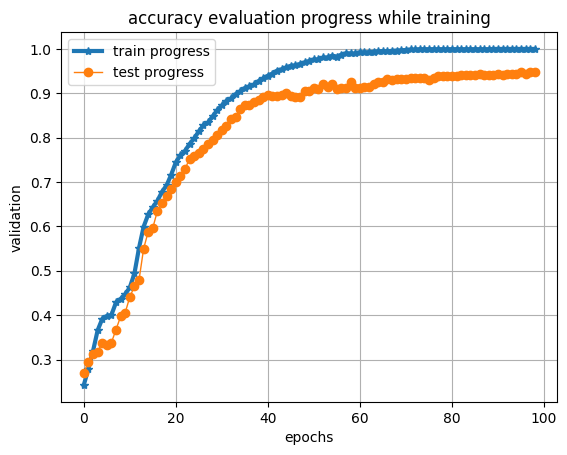

In [16]:
def plot_evaluation(train_progress, test_progress, title):
    '''function to plot the progress of training and testing data'''

    # convert the train accuracy list into numpy array.
    train_line_val = np.array([val for val in train_progress])
    # convert the train accuracy list into numpy array.
    test_line_val = np.array([val for val in test_progress])

    # plot the progress of training accuracy over epochs.
    train_progress, = plt.plot((range(len(train_line_val))), train_line_val, label="train progress", marker="*", linewidth=3)
    # plot the progress of testing accuracy over epochs.
    test_progress, = plt.plot((range(len(test_line_val))), test_line_val, label="test progress", marker="o", linewidth=1)

    # set the legend parameters.
    plt.legend(loc="best", handles=[train_progress, test_progress])
    # write the figure title.
    plt.title(title)
    # write the label of x axis.
    plt.xlabel("epochs")
    # write the label of y axis.
    plt.ylabel("validation")
    # add grid to the figure
    plt.grid(which='major')
    # to show the figure and remove any unwanted appered words
    plt.show()

plot_evaluation(evaluations_progress[:, 0, 0], evaluations_progress[:, 1, 0], 'accuracy evaluation progress while training')

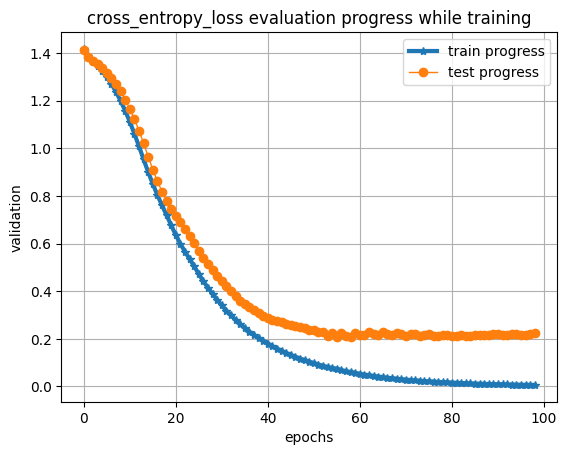

In [17]:
plot_evaluation(evaluations_progress[:, 0, 1], evaluations_progress[:, 1, 1], 'cross_entropy_loss evaluation progress while training')

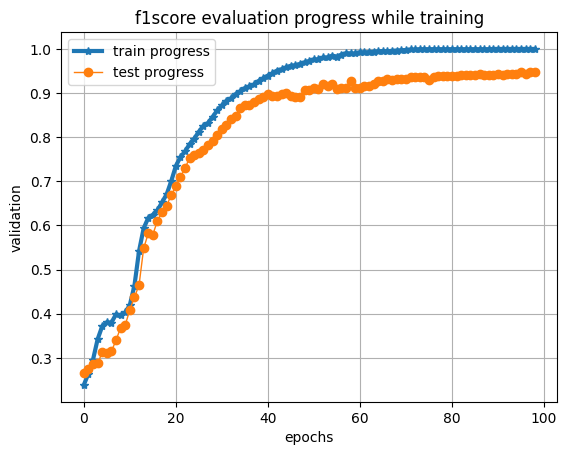

In [18]:
plot_evaluation(evaluations_progress[:, 0, 2], evaluations_progress[:, 1, 2], 'f1score evaluation progress while training')